# 데이콘 이상탐지 데이터 분석
---

In [1]:
!pip install --upgrade matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\leonk\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


![관망구조B](관망구조_B.jpg)

# M7펌프가 24/06/26 05:58 1에서 0으로 변함
# 압력계가 비정상이되면 14:20-부터 급격히 떨어지다가 정상화된 14:50부터 다시 올라감
- P가 anomaly 관측에 주요 변수로 보임(P8)
- 밸브 개도율 수시 변동과 p8 p9 사이 상관관계 가능
- Q4는 굉장히 중요한 변수다
- Q5가 완전 음에서 완전 양으로 바뀐다
- p7하고 q4가 상관관계 -1에 가까워 q4와 p7사이에 밸브는 개도율이 수시로 변동한다 
- p7이 압력이 높아졌을 때 밸브를 닫아서 q4의 유량이 감소했을 가능성이 있음
- 베르누이 원리에 의해서 정상상태에서는 유량과 압력이 음의 상관관계다
- 근데 anomaly상황에서 q5에서 양의 상관관계다
Anomaly 상황에서 유량과 압력이 양의 상관관계를 보이는 것은 시스템에 비정상적인 상태가 발생했음을 시사합니다. 이는 다음과 같은 상황을 나타낼 수 있습니다:
누수 발생: 파이프라인에 누수가 발생하면, 압력이 증가함에 따라 누수 지점을 통한 유량도 증가할 수 있습니다2. 이는 정상적인 흐름과는 다른 패턴을 보이게 됩니다.
막힘 현상: 파이프라인에 부분적인 막힘이 발생하면, 압력이 증가하면서 동시에 유량도 증가할 수 있습니다. 이는 막힘을 통과하기 위해 더 높은 압력이 필요하기 때문입니다2.
펌프 오작동: 시스템 내 펌프가 비정상적으로 작동하면, 압력과 유량이 동시에 증가하는 현상이 나타날 수 있습니다3.
밸브 오작동: 제어 밸브가 제대로 작동하지 않으면, 압력과 유량 사이의 정상적인 관계가 무너질 수 있습니다.
결론
이러한 관찰 결과는 시스템의 정상 상태와 비정상 상태를 구분하는 중요한 지표가 될 수 있습니다4. 유량과 압력 사이의 관계가 갑자기 변화하는 것은 시스템에 문제가 발생했음을 나타내는 신호일 수 있으며, 이를 통해 조기에 문제를 감지하고 대응할 수 있습니다. 따라서 이러한 패턴 변화를 모니터링하는 것은 수도 공급 시스템의 효율적인 관리와 유지보수에 매우 중요합니다5.

# 데이터 정보

In [3]:
df_A = pd.read_csv("TRAIN_B.csv")

print(df_A.columns)
print("칼럼 수 : ",len(df_A.columns))
print("차원 : ",df_A.shape)


# 새로운 열 생성:
df_A['leakage'] = df_A['Q1'] - df_A['Q2'] -df_A['Q3'] - df_A['Q4']

Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9', 'P10', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag'],
      dtype='object')
칼럼 수 :  26
차원 :  (41760, 26)


In [4]:
# 결과 확인 (처음 5행 출력)
print(df_A[['Q1', 'Q2', 'Q3', 'Q4', 'leakage']].head())

           Q1         Q2     Q3         Q4    leakage
0  29277.5000  7387.1660  12025  9522.8721   342.4619
1  28694.5293  7378.3496  11855  9555.6641   -94.4844
2  28814.8457  7399.6729  12005  9555.6641  -145.4913
3  29249.0625  7321.3125  12136  9451.0967   340.6533
4  30138.2793  7315.5610  12158  9451.0967  1213.6216


In [5]:
df_A.head()

timestamp          Q1         Q2     Q3         Q4     P1      P2  \
0  24/07/01 00:00  29277.5000  7387.1660  12025  9522.8721  4.990  3.6862   
1  24/07/01 00:01  28694.5293  7378.3496  11855  9555.6641  4.990  3.6862   
2  24/07/01 00:02  28814.8457  7399.6729  12005  9555.6641  4.965  3.6875   
3  24/07/01 00:03  29249.0625  7321.3125  12136  9451.0967  4.990  3.6875   
4  24/07/01 00:04  30138.2793  7315.5610  12158  9451.0967  4.990  3.6850   

       P3      P4      P5  ...  P2_flag  P3_flag  P4_flag  P5_flag  P6_flag  \
0  3.6875  3.9337  4.0850  ...        0        0        0        0        0   
1  3.6925  3.9313  4.0813  ...        0        0        0        0        0   
2  3.6888  3.9313  4.0837  ...        0        0        0        0        0   
3  3.6950  3.9288  4.0800  ...        0        0        0        0        0   
4  3.7037  3.9331  4.0887  ...        0        0        0        0        0   

   P7_flag  P8_flag  P9_flag  P10_flag    leakage  
0        0        0        0         0   342.4619  
1        0        0        0         0   -94.4844  
2        0        0        0         0  -145.4913  
3        0        0        0         0   340.6533  
4        0        0        0         0  1213.6216  

[5 rows x 27 columns]

In [6]:
df_A.columns

Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9', 'P10', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag', 'leakage'],
      dtype='object')

`-` 해결해야할 문제 : P 압력계에서 일어나는 이상치를 탐지

- Q1 ~ Q4 : 유량 정량 정보
- M없음, 펌프가 없음
- P1 ~ P10 : 해당 펌프의 상수도의 압력계 정량 정보 0이면 정상 1이면 이상치!!
- P1_flag ~ P10_flag : 어떠한 P에 이상 탐지 여부, 이진 분류, test set에선 제공되지 않는다
- anomaly : 이상 탐지 여부, train set에서만 존재, P1_flag ~ P26_flag에서 감지되면 해당 변수에서도 체크된다, test set에선 제공되지 않는다
- Data set : $ D_{train} \in R^{n \times m} $ , $n = 1,2,...,44101,\quad m = 1,2,...,73$
- $n$단위는 1분, 결측치 존재 X


---
# EDA 
- 이상탐지여부 중심으로 진행
- 매우 낮은 이상치 갯수 

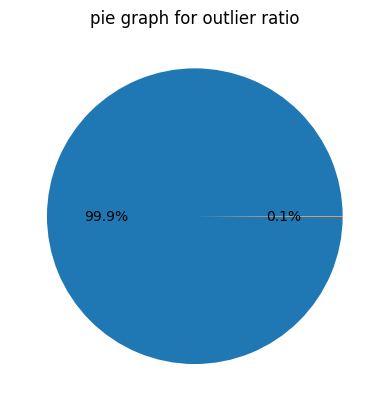

In [7]:
plt.pie(df_A[["anomaly"]].value_counts(),autopct='%1.1f%%')
plt.title("pie graph for outlier ratio")
plt.show()

In [8]:
df_true = df_A[df_A["anomaly"] == 1].iloc[:,1:(4+10+1)]
df_false = df_A[df_A["anomaly"] != 1].iloc[:,1:(4+10+1)]

## Q1~Q5 박스플랏
- 시계열 데이터를 박스플랏으로 보기는 조금 난해하지만 이상치가 표본으로부터 얼마나 거리가 떨어져있는지 확인하기 위해 박스플랏을 그려보았다
- Q3는 다른 데이터에 비해 분포가 매우 큰 차이가 날 것으로 보인다.

C:\Users\leonk\AppData\Local\Temp\ipykernel_10332\3450454212.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[row, col].boxplot(
C:\Users\leonk\AppData\Local\Temp\ipykernel_10332\3450454212.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[row, col].boxplot(
C:\Users\leonk\AppData\Local\Temp\ipykernel_10332\3450454212.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[row, col].boxplot(
C:\Users\leonk\AppData\Local\Temp\ipykernel_10332\3450454212.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will 

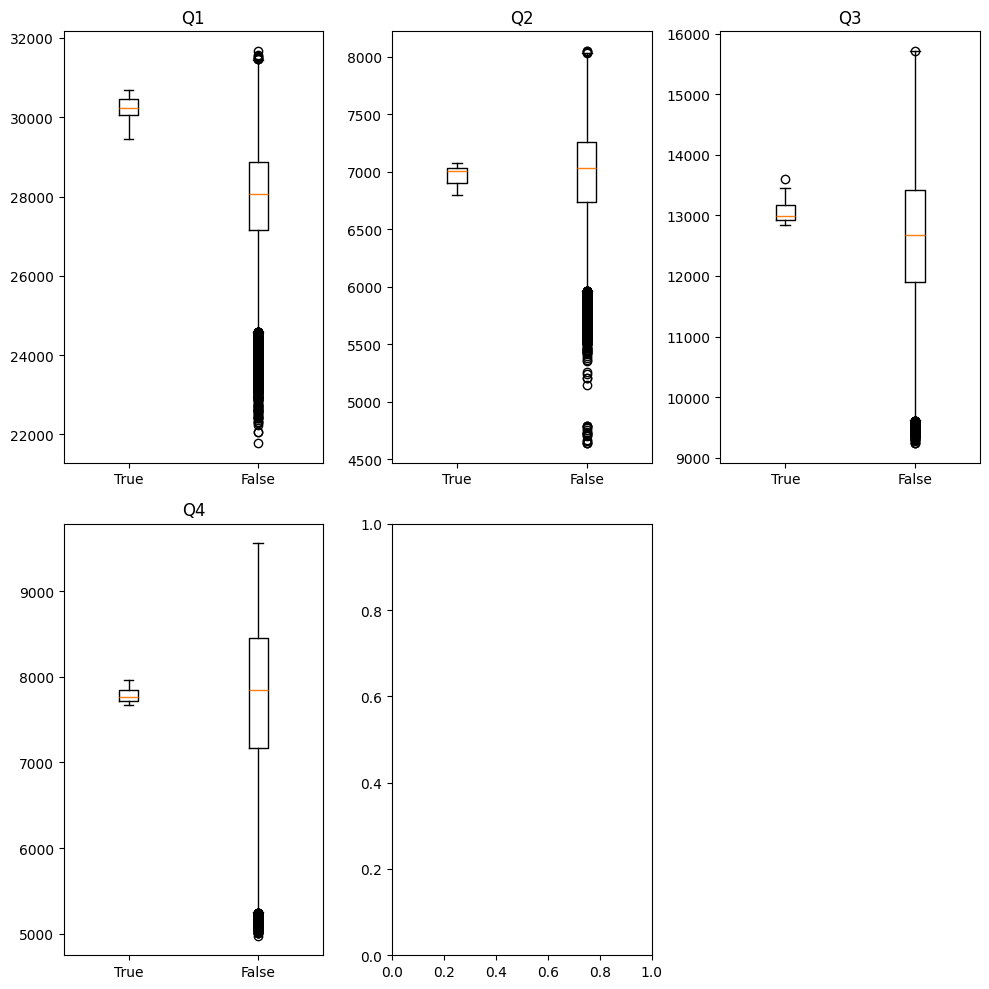

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

titles = ["Q1", "Q2", "Q3", "Q4"]
data = [df_true.iloc[:, i].values for i in range(4)]
labels = ["True", "False"]

for i in range(4):
    row, col = divmod(i, 3)  # 2x3 배열에서 행(row)과 열(col) 계산
    ax[row, col].boxplot(
        [data[i], df_false.iloc[:, i].values], 
        labels=labels
    )
    ax[row, col].set_title(titles[i])

# 필요 없는 격자 숨기기 (마지막 서브플롯)
ax[1, 2].axis("off")

plt.tight_layout()  # 레이아웃 조정
plt.show()

## Q1~Q4 시도표
- 그래프를 통해, 시계열 추세가 매우 변동이 큰 것을 보아 포인트를 찾는 이상치 기법보단 구간별로 이상치를 찾아야할 것으로 보인다.

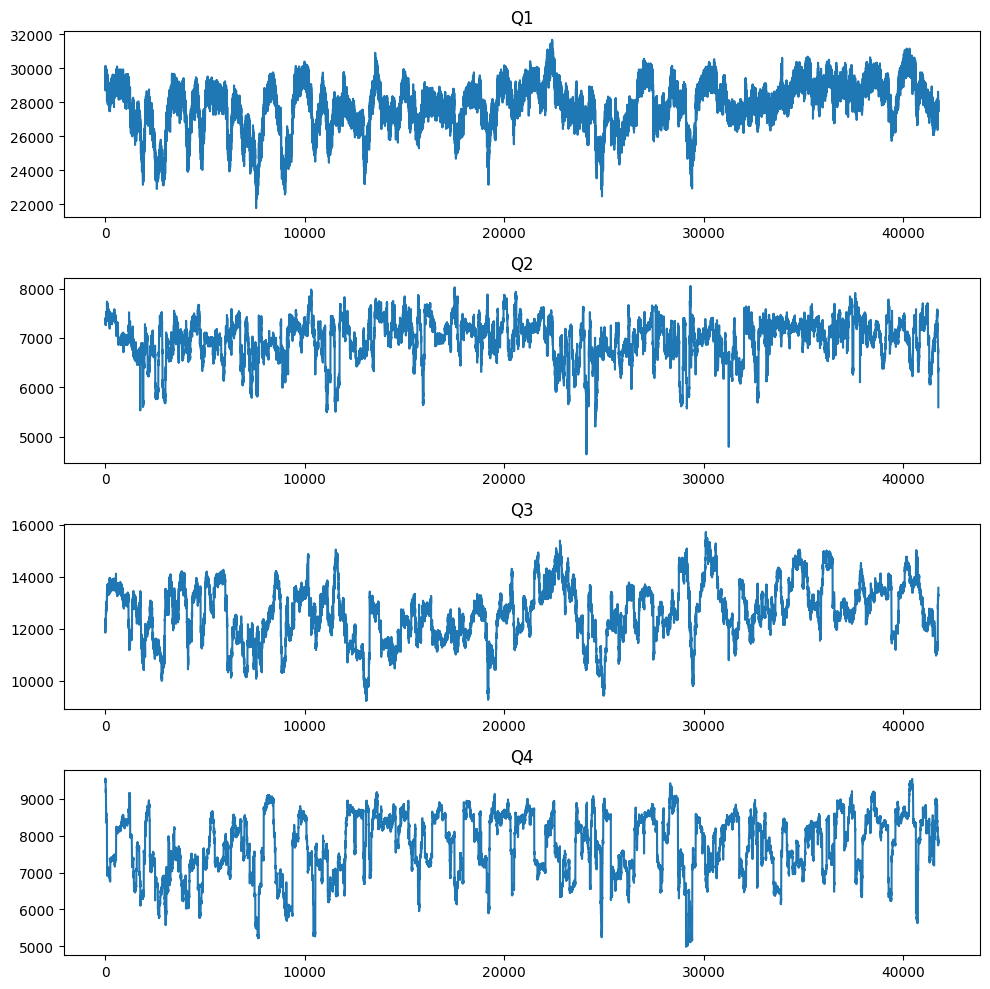

In [10]:
fig, ax = plt.subplots(4,1,figsize=(10,10))
for i in range(0,4):
    ax[i].plot(df_A[f'Q{i+1}'])
    ax[i].set_title(titles[i])

plt.tight_layout()
plt.show()

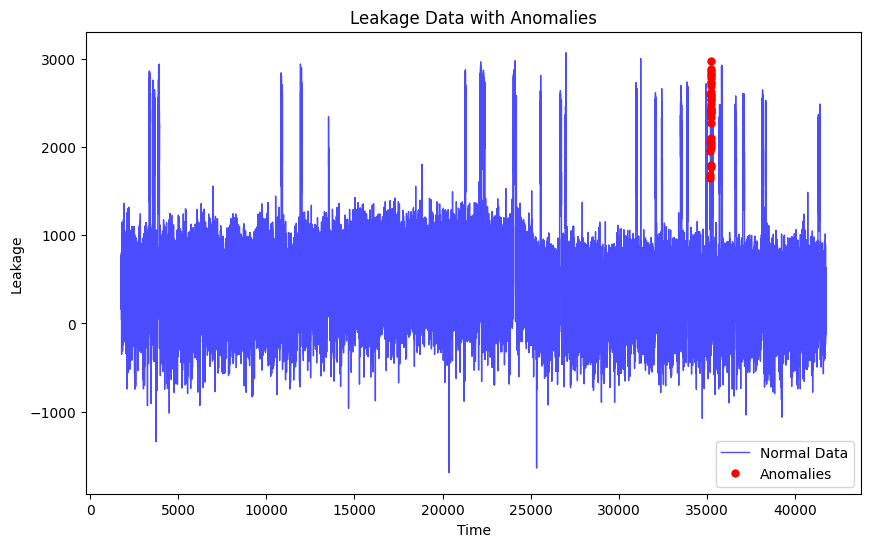

In [11]:
# 그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))

# 정상 데이터 플롯
ax.plot(
    df_A.index[-40000:],  # 시간 축
    df_A['leakage'][-40000:],  # leakage 데이터
    label="Normal Data",
    color="blue",
    linewidth=1,
    alpha=0.7
)

# 이상치 데이터 플롯
ax.plot(
    df_A.index[df_A["anomaly"] == 1],  # 이상치의 시간
    df_A['leakage'][df_A["anomaly"] == 1],  # 이상치의 leakage 값
    label="Anomalies",
    color="red",
    marker='o',
    linestyle='None',
    markersize=5
)

# 그래프 설정
ax.set_title('Leakage Data with Anomalies')
ax.set_xlabel('Time')
ax.set_ylabel('Leakage')
ax.legend()

plt.show()

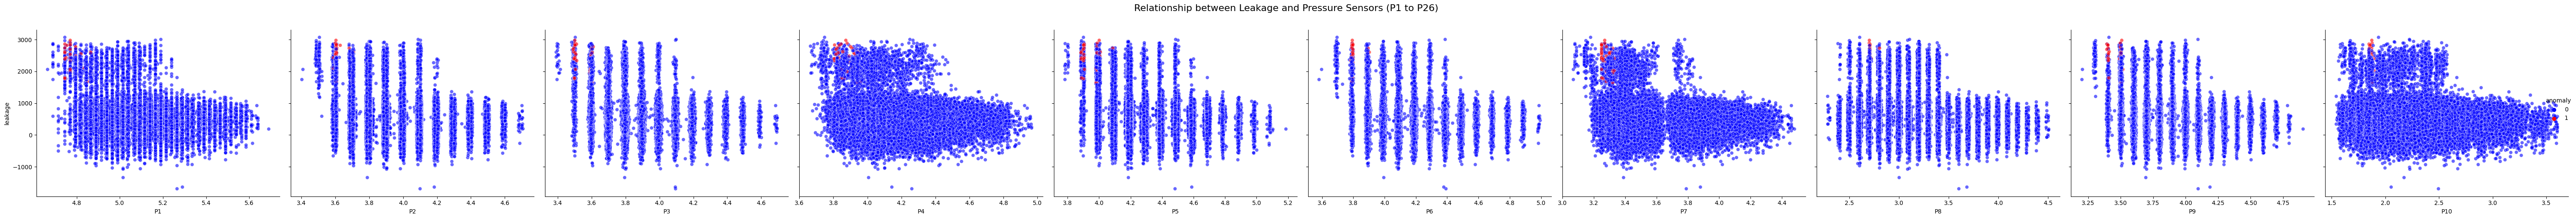

In [12]:
# Select pressure sensor data (P1 to P26), leakage, and anomaly
data_pressure = df_A[['leakage', 'anomaly'] + [f'P{i}' for i in range(1, 11)]]

# Create a pairplot for pressure sensors vs leakage with anomaly highlighting
palette = {0: 'blue', 1: 'red'}  # Normal data in blue, anomalies in red
g = sns.pairplot(
    data_pressure,
    y_vars=['leakage'],
    x_vars=[f'P{i}' for i in range(1, 11)],
    hue='anomaly',
    palette=palette,
    kind='scatter',
    height=5,
    aspect=1.2,
    plot_kws={'alpha': 0.6}
)

# Adjust the layout and title
g.fig.suptitle('Relationship between Leakage and Pressure Sensors (P1 to P26)', y=1.02, fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()
#p_flag에 대한 인사이트 보인다. p7,8,9에서 확실히

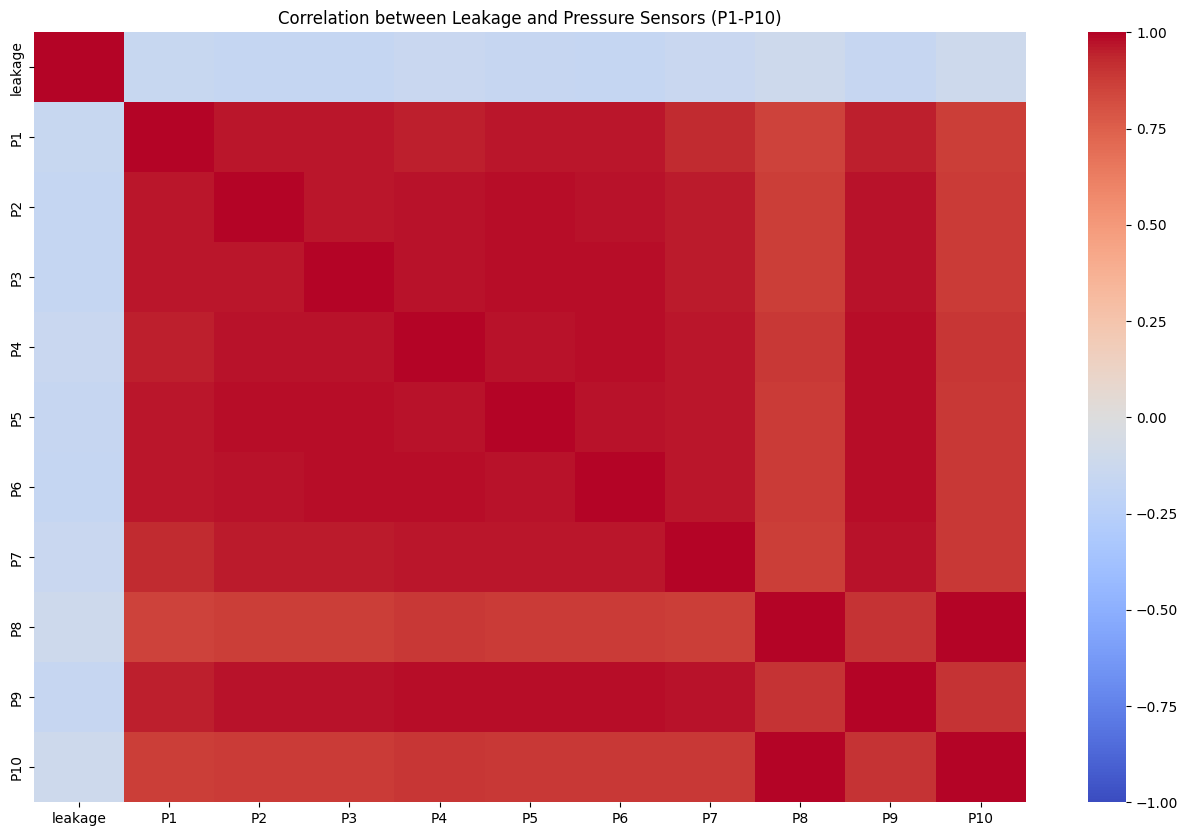

In [15]:
# 압력 센서 데이터(P1~P26)와 누수 데이터 상관관계 히트맵
plt.figure(figsize=(16, 10))
pressure_corr = df_A[['leakage'] + [f'P{i}' for i in range(1, 11)]].corr()
sns.heatmap(pressure_corr, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation between Leakage and Pressure Sensors (P1-P10)')
plt.show()

## 이상치 구간 시각화

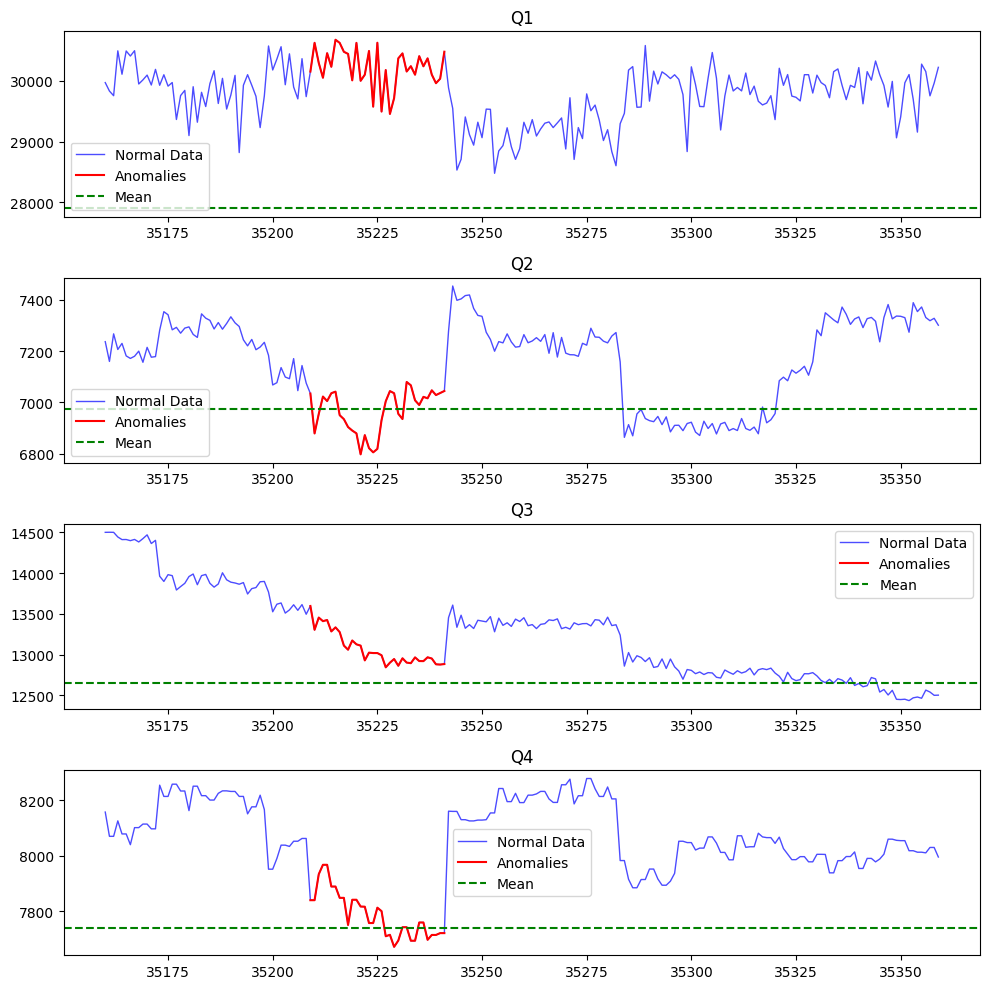

In [18]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# 제목 설정
titles = ["Q1", "Q2", "Q3", "Q4"]

for i in range(4):
    # 정상 데이터 플롯
    ax[i].plot(
        df_A.index[-6600:-6400],  # 시간 축
        df_A[f"Q{i+1}"][-6600:-6400],  # Q 데이터
        label="Normal Data",
        color="blue",
        linewidth=1,
        alpha=0.7
    )

    # 이상치 데이터 플롯
    ax[i].plot(
        df_A.index[df_A["anomaly"] == 1],  # 이상치의 시간
        df_A[f"Q{i+1}"][df_A["anomaly"] == 1],  # 이상치의 값
        label="Anomalies",
        color="red",
        linewidth=1.5  # 두께 강조
    )

    # 제목과 범례 추가
    ax[i].set_title(titles[i])
    ax[i].legend()
    mean_value = df_A[f"Q{i+1}"].mean()  # 평균값 계산
    ax[i].axhline(mean_value, color="green", linestyle="--", label="Mean")  # 수평선 추가

    # 제목 및 범례 추가
    ax[i].set_title(f'Q{i+1}')
    ax[i].legend()
plt.tight_layout()  # 레이아웃 조정
plt.show()

## M이없음

## P1 ~ P10 시도표
- 관망구조를 보면 P1부터 P10은 하나의 구조로 이루어져 있는 것을 확인하였다.
- 이는 서로 집계되는 압력이 어느정도 상관관계가 있을 것으로 보이며, 다변량 문제로 접근해봐야 한다는 의미로도 볼 수 있다.
- 시도표에서도 추세, 계절 성분으로 보이는 것들이 근접한 P 사이에서 대체적으로 비슷하게 나타나 있는 것을 확인할 수 있었다. 

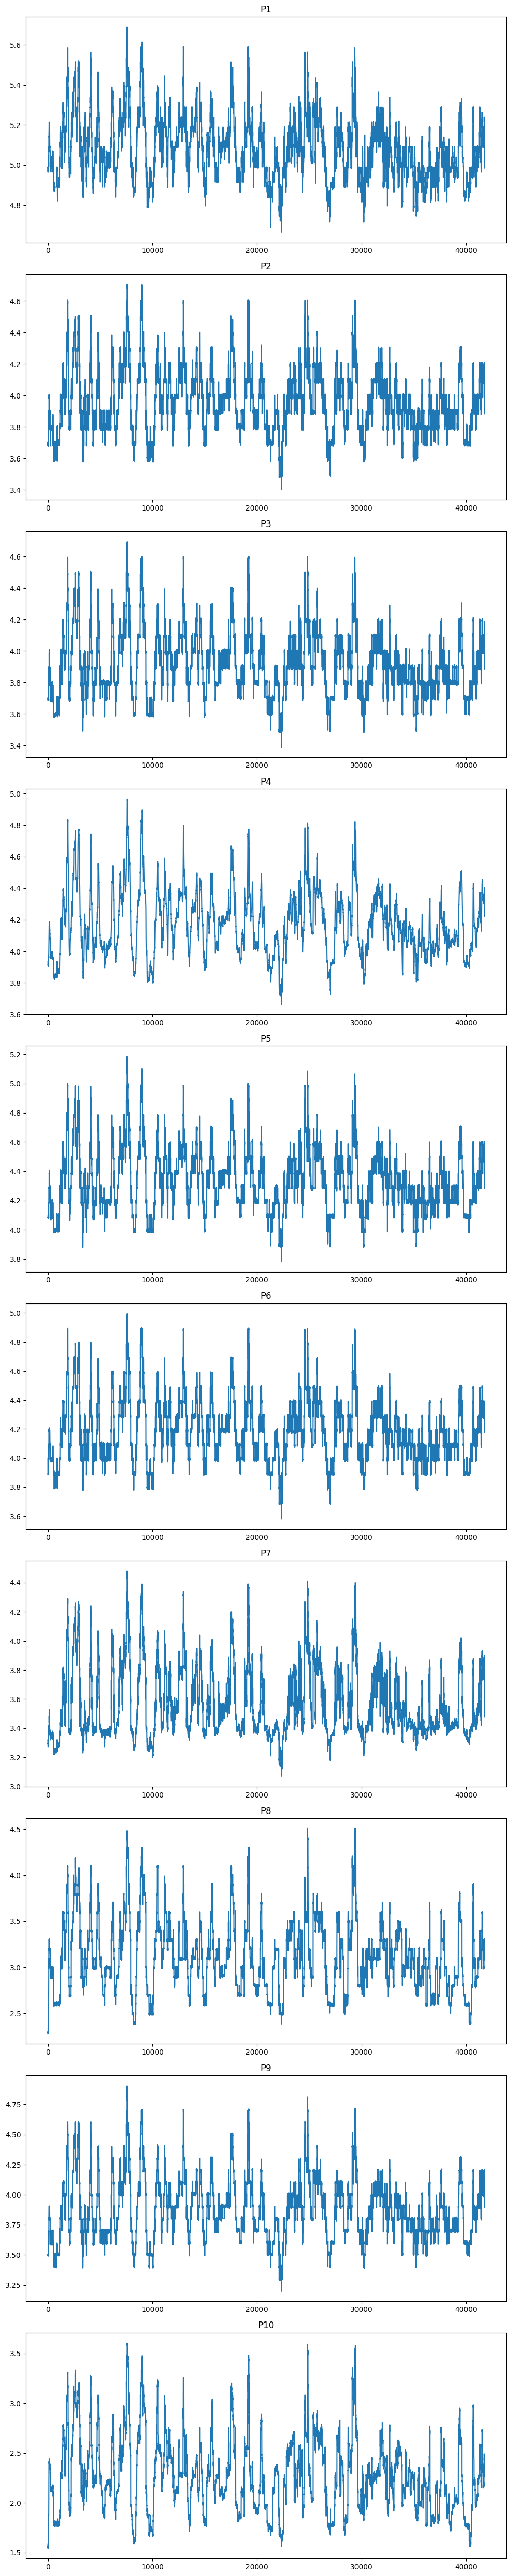

In [19]:
P = df_true.columns[[df_true.columns[i][0] == 'P' for i in range(len(df_true.columns))]]

fig, ax = plt.subplots(len(P),1,figsize=(10,50))
df_Ap= df_A[P]
for i in range(len(P)):
    ax[i].plot(df_Ap[f'P{i+1}'])
    ax[i].set_title(P[i])

plt.tight_layout()
plt.show()

## 이상치 시각화

- P 데이터는 이상치 여부를 판단하는 아주 중요한 변수로 보인다.
- TEST SET에서도 P의 개수에 따라 제출해야하는 이상치 개수가 달라진다. 예를 들어 TEST-C0000이 P가 10개면, 10개에 대한 이상치 탐지 여부를 제출해야한다는 의미이다.

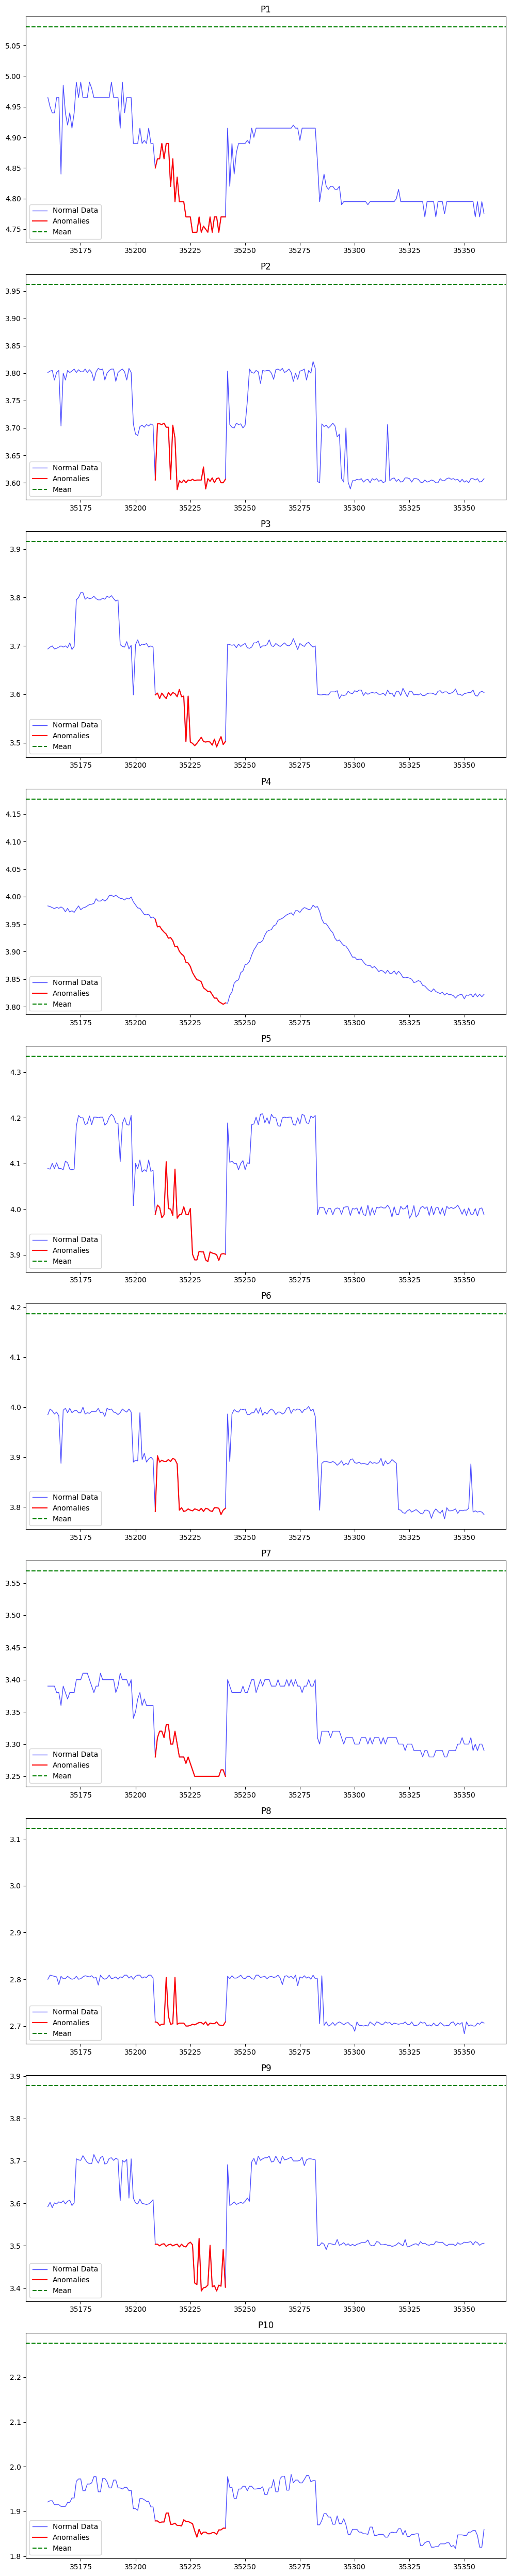

In [60]:
# P로 시작하는 컬럼 선택
P = df_true.columns[[df_true.columns[i][0] == 'P' for i in range(len(df_true.columns))]]
df_Ap = df_A[P]  # P로 시작하는 열만 선택

# 플롯 생성
fig, ax = plt.subplots(len(P), 1, figsize=(10, 50))

for i in range(len(P)):
    # 정상 데이터 플롯
    ax[i].plot(
        df_A.index[-6600:-6400],  # 시간 축
        df_Ap[P[i]][-6600:-6400],  # P 데이터
        label="Normal Data",
        color="blue",
        linewidth=1,
        alpha=0.7
    )

    # 이상치 데이터 플롯
    ax[i].plot(
        df_A.index[df_A["anomaly"] == 1],  # 이상치 시간
        df_Ap[P[i]][df_A["anomaly"] == 1],  # 이상치 값
        label="Anomalies",
        color="red",
        linewidth=1.5  # 두께 강조
    )

    # 평균선 추가
    mean_value = df_Ap[P[i]].mean()  # 평균값 계산
    ax[i].axhline(mean_value, color="green", linestyle="--", label="Mean")  # 수평선 추가

    # 제목 및 범례 추가
    ax[i].set_title(P[i])
    ax[i].legend()

plt.tight_layout()  # 레이아웃 조정
plt.show()
#압력이 대체로 횡보하다가 움직인다

In [21]:
import pandas as pd

# anomaly == 1인 데이터에서 timestamp 열만 선택
timestamps = df_A[df_A["anomaly"] == 1]["timestamp"]

# DataFrame으로 변환 (엑셀 저장을 위해)
timestamps_df = timestamps.reset_index(drop=True).to_frame(name="timestamp")

# 엑셀 파일로 저장
timestamps_df.to_excel("timestamps.xlsx", index=False)

print("timestamp 데이터가 'timestamps.xlsx' 파일로 저장되었습니다.")

timestamp 데이터가 'timestamps.xlsx' 파일로 저장되었습니다.


In [26]:
timestamps_df

timestamp
0   24/07/25 10:49
1   24/07/25 10:50
2   24/07/25 10:51
3   24/07/25 10:52
4   24/07/25 10:53
5   24/07/25 10:54
6   24/07/25 10:55
7   24/07/25 10:56
8   24/07/25 10:57
9   24/07/25 10:58
10  24/07/25 10:59
11  24/07/25 11:00
12  24/07/25 11:01
13  24/07/25 11:02
14  24/07/25 11:03
15  24/07/25 11:04
16  24/07/25 11:05
17  24/07/25 11:06
18  24/07/25 11:07
19  24/07/25 11:08
20  24/07/25 11:09
21  24/07/25 11:10
22  24/07/25 11:11
23  24/07/25 11:12
24  24/07/25 11:13
25  24/07/25 11:14
26  24/07/25 11:15
27  24/07/25 11:16
28  24/07/25 11:17
29  24/07/25 11:18
30  24/07/25 11:19
31  24/07/25 11:20
32  24/07/25 11:21

In [27]:
print(df_A['timestamp'].min(), df_A['timestamp'].max())

24/07/01 00:00 24/07/29 23:59


In [28]:
df_A[df_A["anomaly"] == 1]

timestamp          Q1         Q2     Q3         Q4     P1      P2  \
35209  24/07/25 10:49  30153.5918  7034.4336  13597  7840.3325  4.850  3.6050   
35210  24/07/25 10:50  30627.1895  6878.8403  13305  7840.3325  4.865  3.7075   
35211  24/07/25 10:51  30295.7793  6954.8823  13455  7934.0571  4.865  3.7075   
35212  24/07/25 10:52  30051.8750  7022.8711  13411  7968.0127  4.890  3.7062   
35213  24/07/25 10:53  30456.5625  7005.2261  13425  7968.0127  4.865  3.7088   
35214  24/07/25 10:54  30232.3457  7035.8726  13285  7889.6045  4.890  3.7013   
35215  24/07/25 10:55  30677.5000  7042.0498  13335  7889.6045  4.890  3.7013   
35216  24/07/25 10:56  30626.0918  6950.0977  13277  7848.7778  4.820  3.6063   
35217  24/07/25 10:57  30479.5293  6934.6392  13112  7848.7778  4.865  3.7050   
35218  24/07/25 10:58  30444.5293  6903.8394  13061  7750.9678  4.795  3.6813   
35219  24/07/25 10:59  30009.2168  6890.0698  13174  7841.9360  4.835  3.5875   
35220  24/07/25 11:00  30626.0918  6879.1748  13127  7841.9360  4.795  3.6037   
35221  24/07/25 11:01  30001.5625  6797.1763  13111  7817.4829  4.795  3.6000   
35222  24/07/25 11:02  30102.1875  6872.3105  12930  7816.8647  4.795  3.6050   
35223  24/07/25 11:03  30492.6543  6821.4238  13025  7757.9434  4.770  3.6000   
35224  24/07/25 11:04  29576.0957  6805.0259  13020  7757.9434  4.770  3.6050   
35225  24/07/25 11:05  30628.2832  6818.4717  13020  7813.3276  4.770  3.6037   
35226  24/07/25 11:06  29495.1543  6930.8428  12993  7800.8223  4.745  3.6063   
35227  24/07/25 11:07  30178.7500  7004.3418  12845  7710.2593  4.745  3.6037   
35228  24/07/25 11:08  29455.7832  7044.1733  12902  7715.4609  4.745  3.6050   
35229  24/07/25 11:09  29717.1875  7035.8301  12947  7671.9971  4.770  3.6050   
35230  24/07/25 11:10  30371.2500  6955.5303  12864  7694.7163  4.745  3.6050   
35231  24/07/25 11:11  30453.2832  6935.0269  12956  7742.8594  4.755  3.6288   
35232  24/07/25 11:12  30154.6875  7079.7949  12903  7742.8594  4.750  3.5887   
35233  24/07/25 11:13  30242.1875  7066.7065  12896  7694.0864  4.745  3.6075   
35234  24/07/25 11:14  30102.1875  7008.1079  12967  7694.0864  4.770  3.6025   
35235  24/07/25 11:15  30407.3457  6989.8188  12922  7759.9199  4.745  3.6088   
35236  24/07/25 11:16  30240.0000  7021.6279  12921  7759.9199  4.770  3.6000   
35237  24/07/25 11:17  30371.2500  7016.0249  12968  7697.3105  4.770  3.6075   
35238  24/07/25 11:18  30103.2832  7047.1992  12953  7714.9678  4.745  3.6088   
35239  24/07/25 11:19  29962.1875  7028.6816  12882  7714.9678  4.770  3.6000   
35240  24/07/25 11:20  30036.5625  7036.5801  12879  7721.5640  4.770  3.6000   
35241  24/07/25 11:21  30480.6250  7044.5557  12885  7721.5640  4.770  3.6063   

           P3      P4      P5  ...  P2_flag  P3_flag  P4_flag  P5_flag  \
35209  3.5988  3.9588  3.9887  ...        0        0        0        0   
35210  3.6025  3.9450  4.0087  ...        0        0        0        0   
35211  3.5912  3.9462  4.0037  ...        0        0        0        0   
35212  3.6025  3.9400  3.9813  ...        0        0        0        0   
35213  3.5963  3.9356  3.9875  ...        0        0        0        0   
35214  3.5912  3.9319  4.1038  ...        0        0        0        0   
35215  3.6037  3.9244  4.0012  ...        0        0        0        0   
35216  3.5975  3.9256  4.0000  ...        0        0        0        0   
35217  3.6037  3.9200  3.9862  ...        0        0        0        0   
35218  3.6012  3.9088  4.0875  ...        0        0        0        0   
35219  3.5950  3.9100  3.9800  ...        0        0        0        0   
35220  3.6100  3.9006  3.9875  ...        0        0        0        0   
35221  3.5950  3.8956  3.9887  ...        0        0        0        0   
35222  3.5963  3.8925  4.0050  ...        0        0        0        0   
35223  3.5025  3.8806  3.9887  ...        0        0        0        0   
35224  3.5963  3.8794  3.9875  ...        0        0        0        0   

In [29]:
#시계열 자료로 변환
df_A['timestamp'] = pd.to_datetime(df_A['timestamp'], format='%y/%m/%d %H:%M')

In [30]:
df_A['timestamp'].head()

0   2024-07-01 00:00:00
1   2024-07-01 00:01:00
2   2024-07-01 00:02:00
3   2024-07-01 00:03:00
4   2024-07-01 00:04:00
Name: timestamp, dtype: datetime64[ns]

In [31]:
# anomaly가 1인 시간대 찾기
anomaly_times = df_A[df_A['anomaly'] == 1]['timestamp']

In [32]:
print(df_A['timestamp'].min(), df_A['timestamp'].max())

2024-07-01 00:00:00 2024-07-29 23:59:00


In [33]:
# anomaly가 1인 연속된 구간 찾기
anomaly_start = df_A[df_A['anomaly'] == 1]['timestamp'].min()
anomaly_end = df_A[df_A['anomaly'] == 1]['timestamp'].max()

In [34]:
anomaly_start

Timestamp('2024-07-25 10:49:00')

In [35]:
anomaly_end

Timestamp('2024-07-25 11:21:00')

In [36]:
# 전후 60분 시간 범위 설정
start_time = anomaly_start - pd.Timedelta(minutes=60)
end_time = anomaly_end + pd.Timedelta(minutes=60)

In [37]:
start_time

Timestamp('2024-07-25 09:49:00')

In [38]:
end_time

Timestamp('2024-07-25 12:21:00')

In [39]:
# 데이터 추출
filtered_data = df_A[(df_A['timestamp'] >= start_time) & (df_A['timestamp'] <= end_time)]

In [40]:
filtered_data

timestamp          Q1         Q2     Q3         Q4     P1  \
35149 2024-07-25 09:49:00  30236.7207  7181.2715  14363  8057.4092  4.965   
35150 2024-07-25 09:50:00  30224.6895  7180.4707  14533  8086.9927  4.965   
35151 2024-07-25 09:51:00  30404.0625  7254.8862  14469  8086.9927  4.965   
35152 2024-07-25 09:52:00  30241.0918  7179.2500  14312  8107.9546  4.965   
35153 2024-07-25 09:53:00  30284.8418  7211.1758  14421  8107.9546  4.965   
...                   ...         ...        ...    ...        ...    ...   
35297 2024-07-25 12:17:00  30025.6250  6910.8574  12800  8053.0151  4.795   
35298 2024-07-25 12:18:00  29774.0625  6889.6548  12699  8053.0151  4.795   
35299 2024-07-25 12:19:00  28836.7207  6917.6006  12818  8048.1670  4.795   
35300 2024-07-25 12:20:00  30231.2500  6922.5815  12808  8048.1670  4.795   
35301 2024-07-25 12:21:00  29938.1250  6884.0762  12767  8021.4209  4.795   

           P2      P3      P4      P5  ...  P2_flag  P3_flag  P4_flag  \
35149  3.8063  3.7000  3.9950  4.0862  ...        0        0        0   
35150  3.8038  3.6975  3.9906  4.1025  ...        0        0        0   
35151  3.7875  3.6975  3.9875  4.1038  ...        0        0        0   
35152  3.8000  3.7000  3.9850  4.0800  ...        0        0        0   
35153  3.8000  3.7037  3.9838  4.0850  ...        0        0        0   
...       ...     ...     ...     ...  ...      ...      ...      ...   
35297  3.6012  3.6063  3.9044  4.0050  ...        0        0        0   
35298  3.5887  3.6025  3.8975  3.9862  ...        0        0        0   
35299  3.6037  3.6012  3.8900  4.0012  ...        0        0        0   
35300  3.6037  3.6075  3.8900  4.0000  ...        0        0        0   
35301  3.6063  3.6050  3.8856  4.0025  ...        0        0        0   

       P5_flag  P6_flag  P7_flag  P8_flag  P9_flag  P10_flag    leakage  
35149        0        0        0        0        0         0   635.0400  
35150        0        0        0        0        0         0   424.2261  
35151        0        0        0        0        0         0   593.1836  
35152        0        0        0        0        0         0   641.8872  
35153        0        0        0        0        0         0   544.7114  
...        ...      ...      ...      ...      ...       ...        ...  
35297        0        0        0        0        0         0  2261.7525  
35298        0        0        0        0        0         0  2132.3926  
35299        0        0        0        0        0         0  1052.9531  
35300        0        0        0        0        0         0  2452.5015  
35301        0        0        0        0        0         0  2265.6279  

[153 rows x 27 columns]

In [41]:
filtered_data.head()

timestamp          Q1         Q2     Q3         Q4     P1  \
35149 2024-07-25 09:49:00  30236.7207  7181.2715  14363  8057.4092  4.965   
35150 2024-07-25 09:50:00  30224.6895  7180.4707  14533  8086.9927  4.965   
35151 2024-07-25 09:51:00  30404.0625  7254.8862  14469  8086.9927  4.965   
35152 2024-07-25 09:52:00  30241.0918  7179.2500  14312  8107.9546  4.965   
35153 2024-07-25 09:53:00  30284.8418  7211.1758  14421  8107.9546  4.965   

           P2      P3      P4      P5  ...  P2_flag  P3_flag  P4_flag  \
35149  3.8063  3.7000  3.9950  4.0862  ...        0        0        0   
35150  3.8038  3.6975  3.9906  4.1025  ...        0        0        0   
35151  3.7875  3.6975  3.9875  4.1038  ...        0        0        0   
35152  3.8000  3.7000  3.9850  4.0800  ...        0        0        0   
35153  3.8000  3.7037  3.9838  4.0850  ...        0        0        0   

       P5_flag  P6_flag  P7_flag  P8_flag  P9_flag  P10_flag   leakage  
35149        0        0        0        0        0         0  635.0400  
35150        0        0        0        0        0         0  424.2261  
35151        0        0        0        0        0         0  593.1836  
35152        0        0        0        0        0         0  641.8872  
35153        0        0        0        0        0         0  544.7114  

[5 rows x 27 columns]

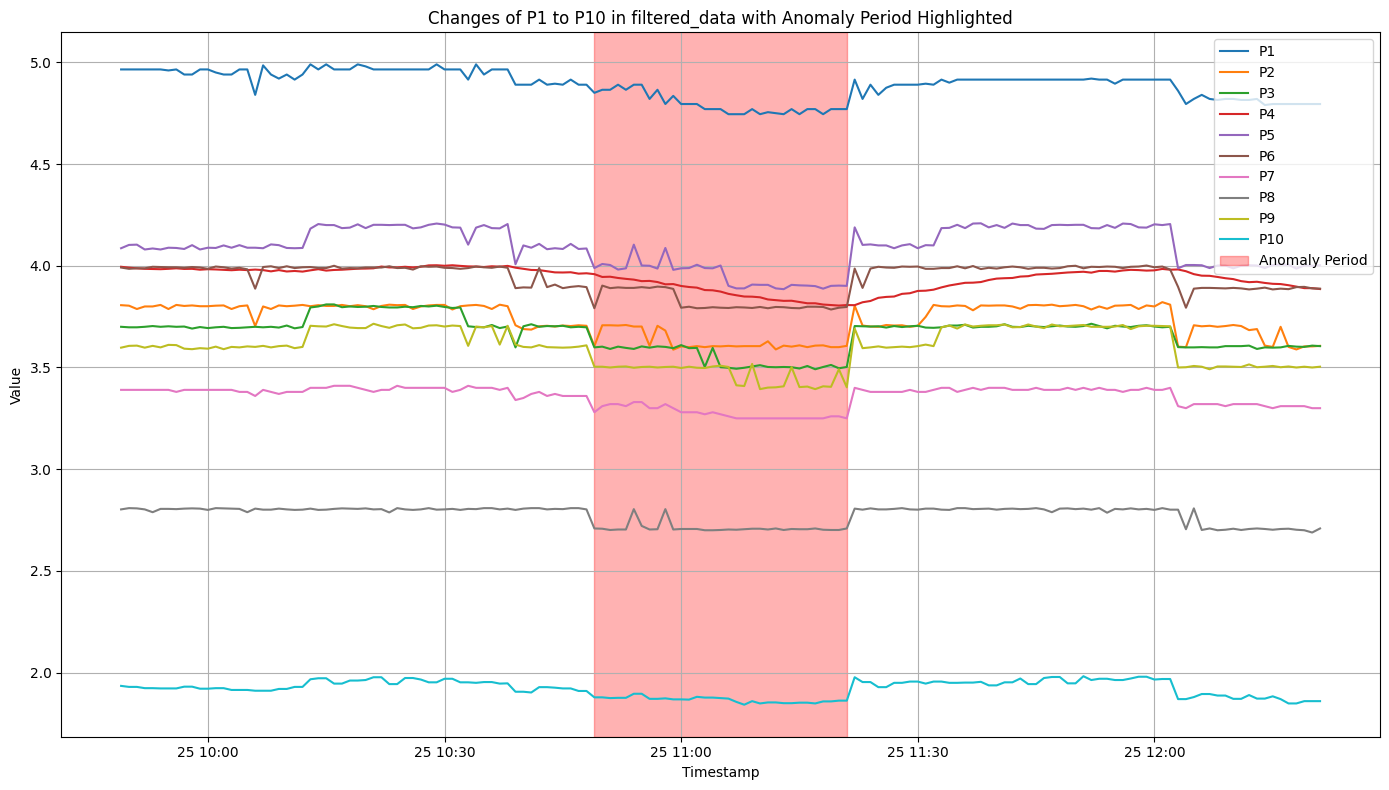

In [42]:
# p1부터 p10까지의 데이터 시각화
plt.figure(figsize=(14, 8))
for i in range(1, 11):
    plt.plot(filtered_data['timestamp'], filtered_data[f'P{i}'], label=f'P{i}')

# anomaly 구간 강조
plt.axvspan(anomaly_start, anomaly_end, color='red', alpha=0.3, label='Anomaly Period')

plt.title('Changes of P1 to P10 in filtered_data with Anomaly Period Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#p,7,8,9

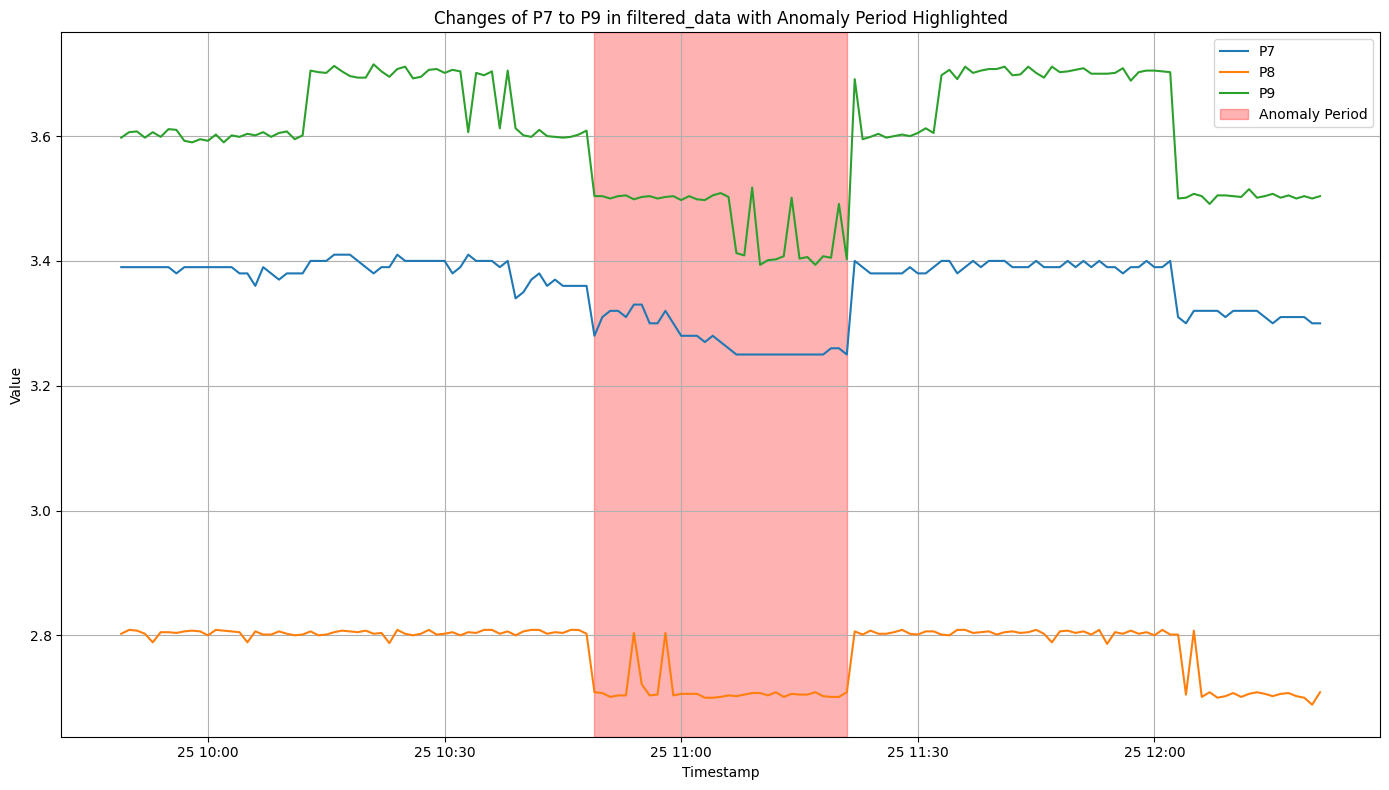

In [43]:
# p1부터 p10까지의 데이터 시각화
plt.figure(figsize=(14, 8))
for i in range(7, 10):
    plt.plot(filtered_data['timestamp'], filtered_data[f'P{i}'], label=f'P{i}')

# anomaly 구간 강조
plt.axvspan(anomaly_start, anomaly_end, color='red', alpha=0.3, label='Anomaly Period')

plt.title('Changes of P7 to P9 in filtered_data with Anomaly Period Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [44]:
print(df_A['timestamp'].min(), df_A['timestamp'].max())

2024-07-01 00:00:00 2024-07-29 23:59:00


In [45]:
print(anomaly_times)

35209   2024-07-25 10:49:00
35210   2024-07-25 10:50:00
35211   2024-07-25 10:51:00
35212   2024-07-25 10:52:00
35213   2024-07-25 10:53:00
35214   2024-07-25 10:54:00
35215   2024-07-25 10:55:00
35216   2024-07-25 10:56:00
35217   2024-07-25 10:57:00
35218   2024-07-25 10:58:00
35219   2024-07-25 10:59:00
35220   2024-07-25 11:00:00
35221   2024-07-25 11:01:00
35222   2024-07-25 11:02:00
35223   2024-07-25 11:03:00
35224   2024-07-25 11:04:00
35225   2024-07-25 11:05:00
35226   2024-07-25 11:06:00
35227   2024-07-25 11:07:00
35228   2024-07-25 11:08:00
35229   2024-07-25 11:09:00
35230   2024-07-25 11:10:00
35231   2024-07-25 11:11:00
35232   2024-07-25 11:12:00
35233   2024-07-25 11:13:00
35234   2024-07-25 11:14:00
35235   2024-07-25 11:15:00
35236   2024-07-25 11:16:00
35237   2024-07-25 11:17:00
35238   2024-07-25 11:18:00
35239   2024-07-25 11:19:00
35240   2024-07-25 11:20:00
35241   2024-07-25 11:21:00
Name: timestamp, dtype: datetime64[ns]


In [46]:
# 숫자형 컬럼만 선택 (timestamp와 같은 비숫자형 컬럼 제외)
numeric_columns = filtered_data.select_dtypes(include=[np.number]).columns

In [47]:
# P8, P9를 포함한 모든 숫자형 컬럼 간의 상관관계 계산
correlation_matrix = filtered_data[numeric_columns].corr()

In [48]:
# P8, P9와 다른 컬럼들 간의 상관관계만 선택
p7_p8_p9correlations = correlation_matrix.loc[['P7','P8', 'P9'], :]

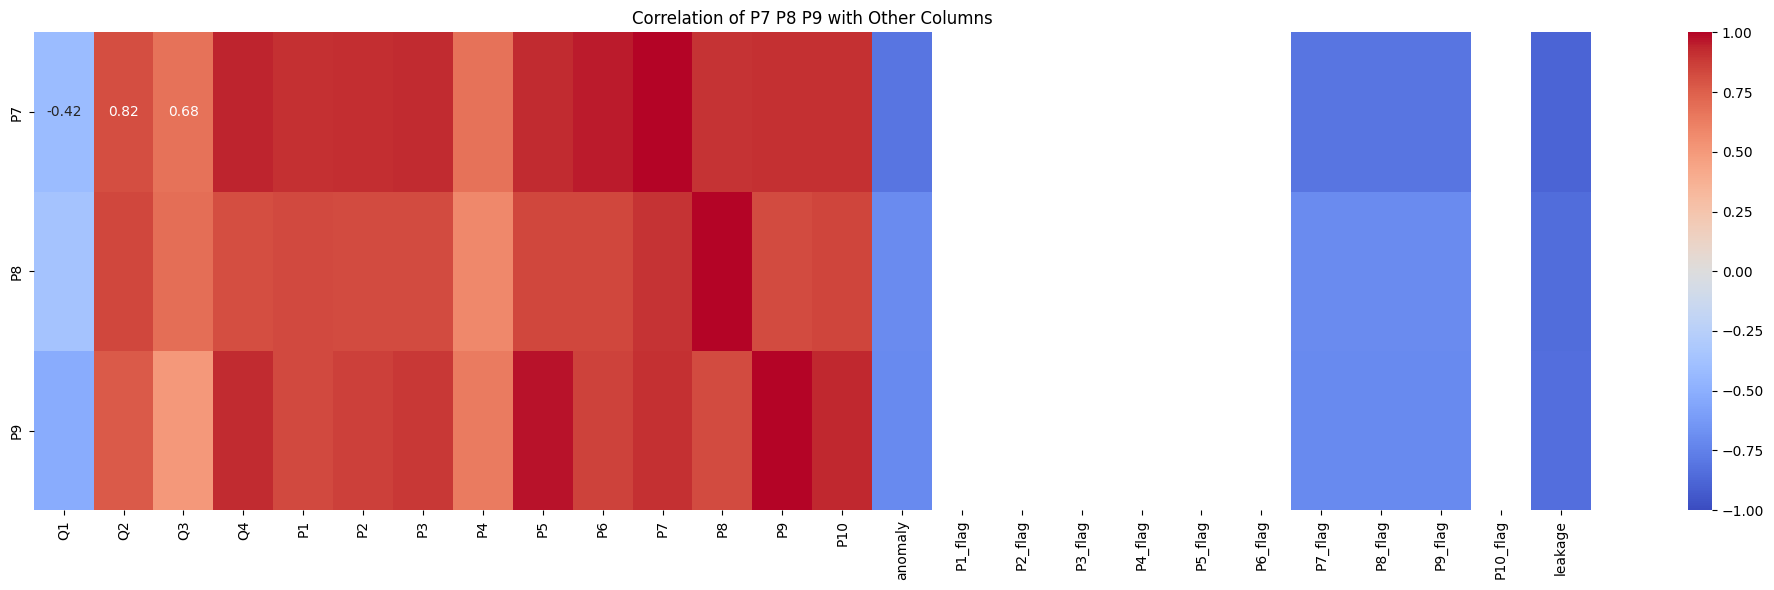

In [49]:
# 히트맵 생성
plt.figure(figsize=(20, 6))
sns.heatmap(p7_p8_p9correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation of P7 P8 P9 with Other Columns')
plt.tight_layout()
plt.show()

In [50]:
print("P7과 가장 상관관계가 높은 상위 10개 컬럼:")
print(correlation_matrix['P7'].sort_values(ascending=False)[1:11])

P7과 가장 상관관계가 높은 상위 10개 컬럼:
P6     0.956398
Q4     0.943236
P5     0.925567
P3     0.923857
P2     0.920680
P1     0.914036
P9     0.913585
P10    0.910160
P8     0.900170
Q2     0.816579
Name: P7, dtype: float64


In [51]:
# P8, P9와 가장 상관관계가 높은 상위 5개 컬럼 출력
print("P8과 가장 상관관계가 높은 상위 10개 컬럼:")
print(correlation_matrix['P8'].sort_values(ascending=False)[1:11])  # P8 자신 제외

P8과 가장 상관관계가 높은 상위 10개 컬럼:
P7     0.900170
P10    0.844482
P6     0.840804
P5     0.837476
Q2     0.837457
P1     0.833802
P3     0.825411
P9     0.825155
P2     0.824345
Q4     0.815065
Name: P8, dtype: float64


In [52]:
print("P9과 가장 상관관계가 높은 상위 10개 컬럼:")
print(correlation_matrix['P9'].sort_values(ascending=False)[1:11])

P9과 가장 상관관계가 높은 상위 10개 컬럼:
P5     0.972196
P10    0.936613
Q4     0.928086
P7     0.913585
P3     0.887832
P2     0.860734
P6     0.859056
P1     0.834503
P8     0.825155
Q2     0.766304
Name: P9, dtype: float64


- Anomaly를 관측할 때 펌프와 압력사이의 상관관계가 0일수록 누수가 났을 가능성이 높다(가설)
- TrainB도 이 가설처럼 나오면 모델을 돌릴때 펌프의 역할은 거의 없을 수도 있다

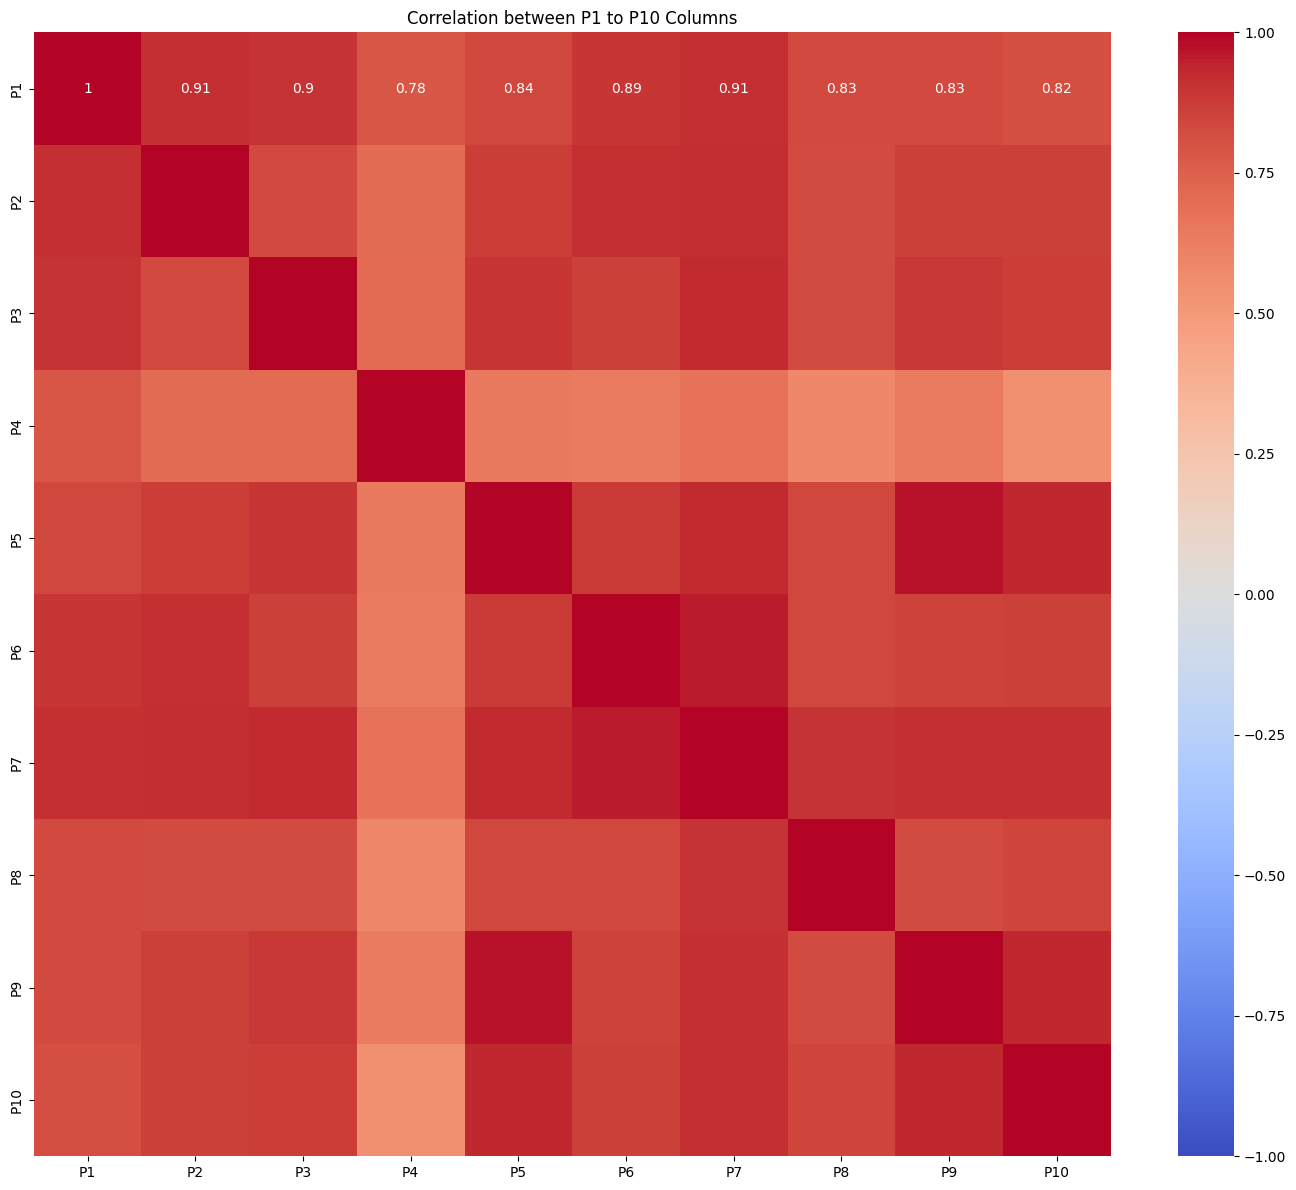

In [53]:
# P1부터 P26까지의 컬럼 선택
p_columns = [f'P{i}' for i in range(1, 11)]

# P1부터 P26까지의 상관관계 계산
correlation_matrix_p = filtered_data[p_columns].corr()

# 히트맵 생성
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_p, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between P1 to P10 Columns')
plt.tight_layout()
plt.show()
#p17은 고인물

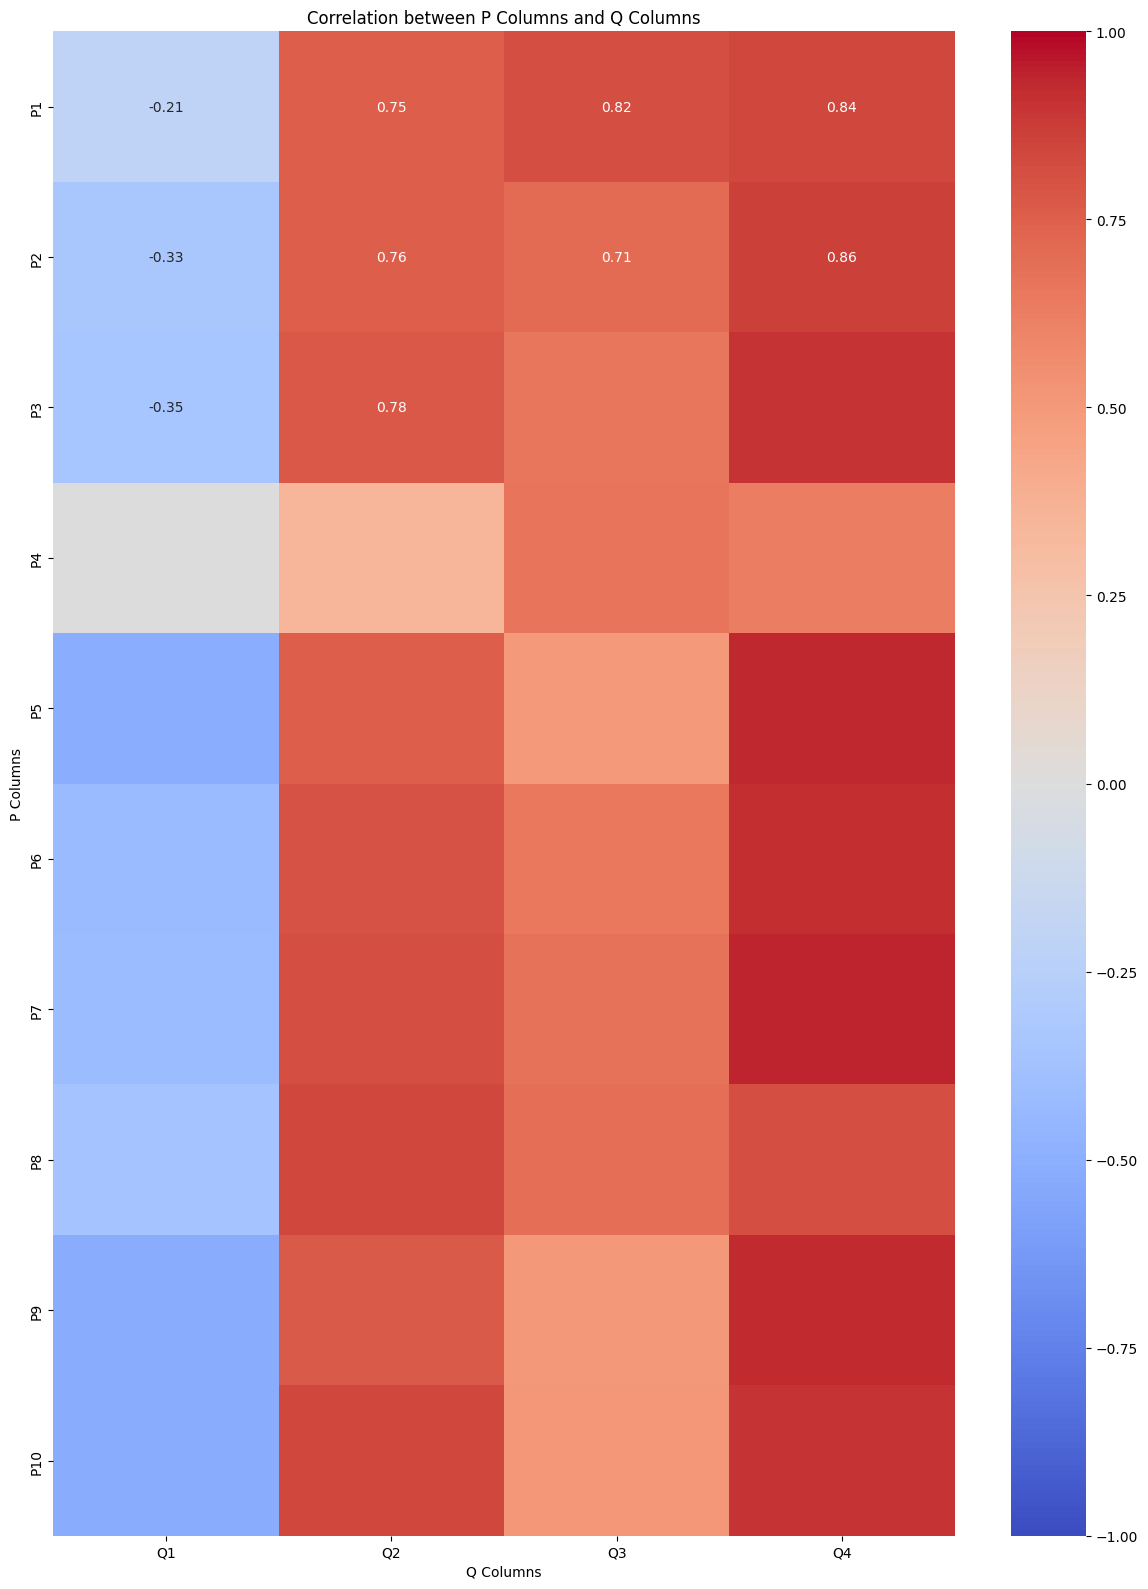

가장 높은 상관관계를 가진 P-Q 쌍 5개:
P7 - Q4: 0.9432
P5 - Q4: 0.9351
P9 - Q4: 0.9281
P6 - Q4: 0.9189
P3 - Q4: 0.9034


In [54]:
# P1부터 P10까지의 컬럼과 Q1부터 Q4까지의 컬럼 선택
p_columns = [f'P{i}' for i in range(1, 11)]
q_columns = [f'Q{i}' for i in range(1, 5)]

# P 컬럼들과 Q 컬럼들 간의 상관관계 계산
correlation_matrix_pq = filtered_data[p_columns + q_columns].corr().loc[p_columns, q_columns]

# 히트맵 생성
plt.figure(figsize=(12, 16))
sns.heatmap(correlation_matrix_pq, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between P Columns and Q Columns')
plt.xlabel('Q Columns')
plt.ylabel('P Columns')
plt.tight_layout()
plt.show()

# 가장 높은 상관관계를 가진 P-Q 쌍 5개 출력
correlation_pairs = []
for p in p_columns:
    for q in q_columns:
        correlation_pairs.append((p, q, correlation_matrix_pq.loc[p, q]))

top_5_correlations = sorted(correlation_pairs, key=lambda x: abs(x[2]), reverse=True)[:5]

print("가장 높은 상관관계를 가진 P-Q 쌍 5개:")
for p, q, corr in top_5_correlations:
    print(f"{p} - {q}: {corr:.4f}")

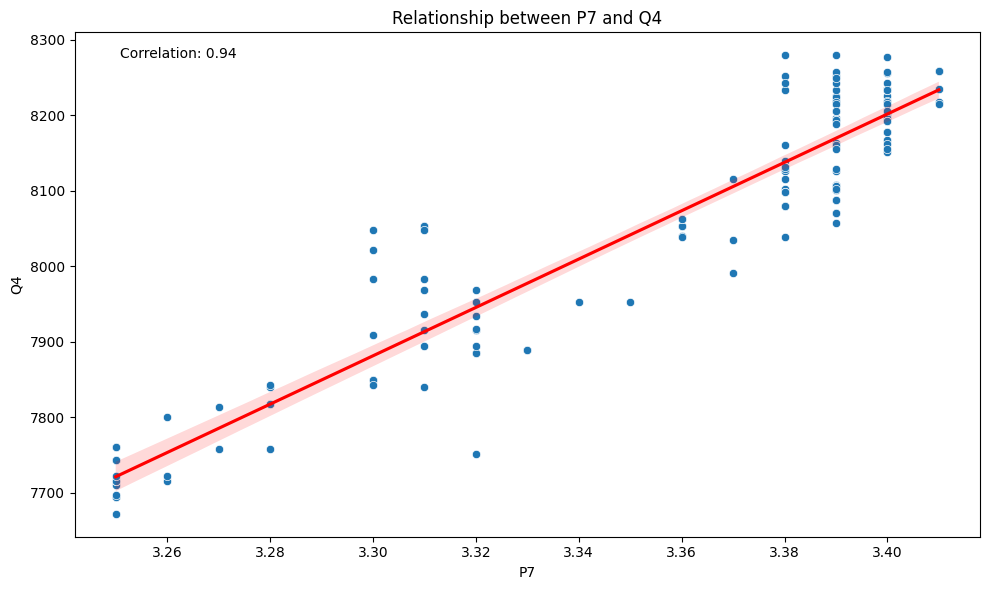

P7와 Q4의 상관계수: 0.9432

기술 통계:
               P7           Q4
count  153.000000   153.000000
mean     3.354771  8056.639749
std      0.051146   173.665426
min      3.250000  7671.997100
25%      3.310000  7916.916000
50%      3.380000  8106.410600
75%      3.390000  8205.795900
max      3.410000  8279.331100


In [55]:
# 산점도 생성
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x='P7', y='Q4')

# 회귀선 추가
sns.regplot(data=filtered_data, x='P7', y='Q4', scatter=False, color='red')

# 그래프 제목과 축 레이블 설정
plt.title('Relationship between P7 and Q4')
plt.xlabel('P7')
plt.ylabel('Q4')

# 상관계수 계산 및 표시
correlation = filtered_data['P7'].corr(filtered_data['Q4'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 추가적인 통계 정보 출력
print(f"P7와 Q4의 상관계수: {correlation:.4f}")
print("\n기술 통계:")
print(filtered_data[['P7', 'Q4']].describe())

## 전체 데이터의 경우

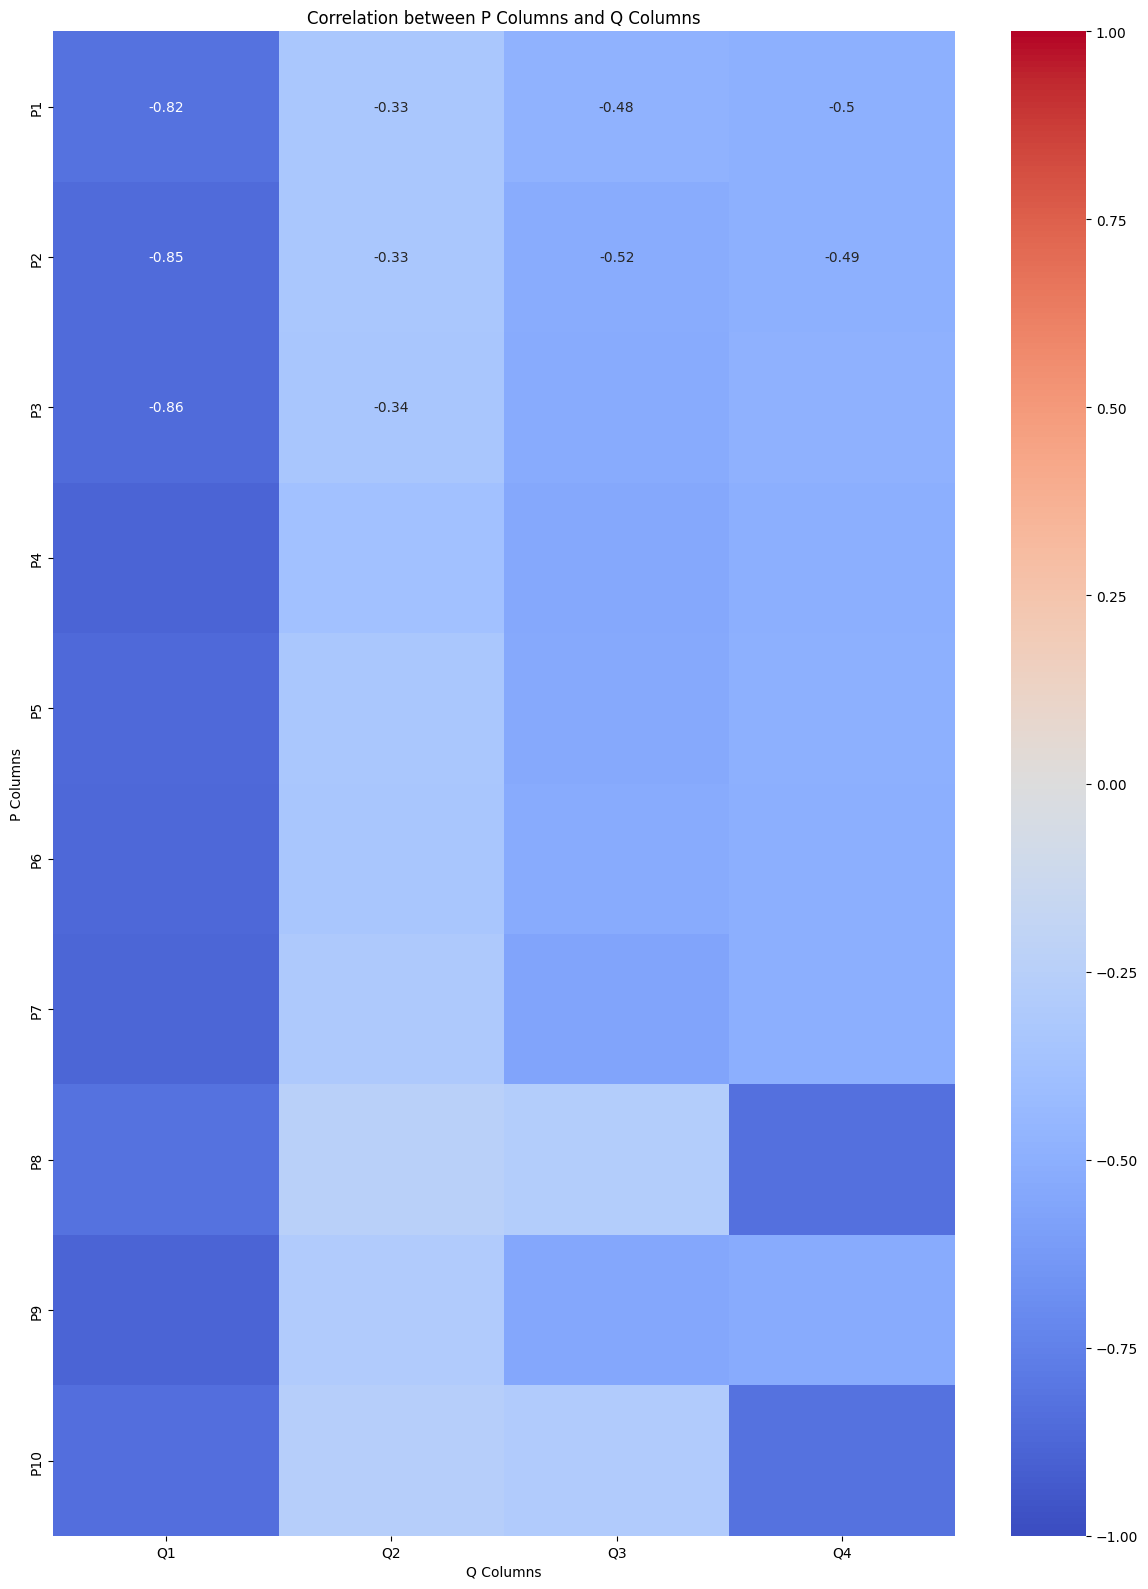

가장 높은 상관관계를 가진 P-Q 쌍 5개:
P9 - Q1: -0.8855
P4 - Q1: -0.8829
P7 - Q1: -0.8815
P6 - Q1: -0.8676
P5 - Q1: -0.8662


In [56]:
# P1부터 P26까지의 컬럼과 Q1부터 Q5까지의 컬럼 선택
p_columns = [f'P{i}' for i in range(1, 11)]
q_columns = [f'Q{i}' for i in range(1, 5)]

# P 컬럼들과 Q 컬럼들 간의 상관관계 계산
correlation_matrix_pq = df_A[p_columns + q_columns].corr().loc[p_columns, q_columns]

# 히트맵 생성
plt.figure(figsize=(12, 16))
sns.heatmap(correlation_matrix_pq, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between P Columns and Q Columns')
plt.xlabel('Q Columns')
plt.ylabel('P Columns')
plt.tight_layout()
plt.show()

# 가장 높은 상관관계를 가진 P-Q 쌍 5개 출력
correlation_pairs = []
for p in p_columns:
    for q in q_columns:
        correlation_pairs.append((p, q, correlation_matrix_pq.loc[p, q]))

top_5_correlations = sorted(correlation_pairs, key=lambda x: abs(x[2]), reverse=True)[:5]

print("가장 높은 상관관계를 가진 P-Q 쌍 5개:")
for p, q, corr in top_5_correlations:
    print(f"{p} - {q}: {corr:.4f}")